In [1]:
import numpy as np
import matplotlib.pyplot as plt

## Possible situations (cases) for the cone of Cherenkov radiation.

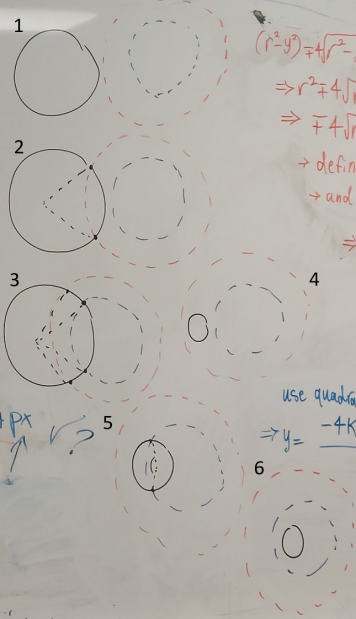

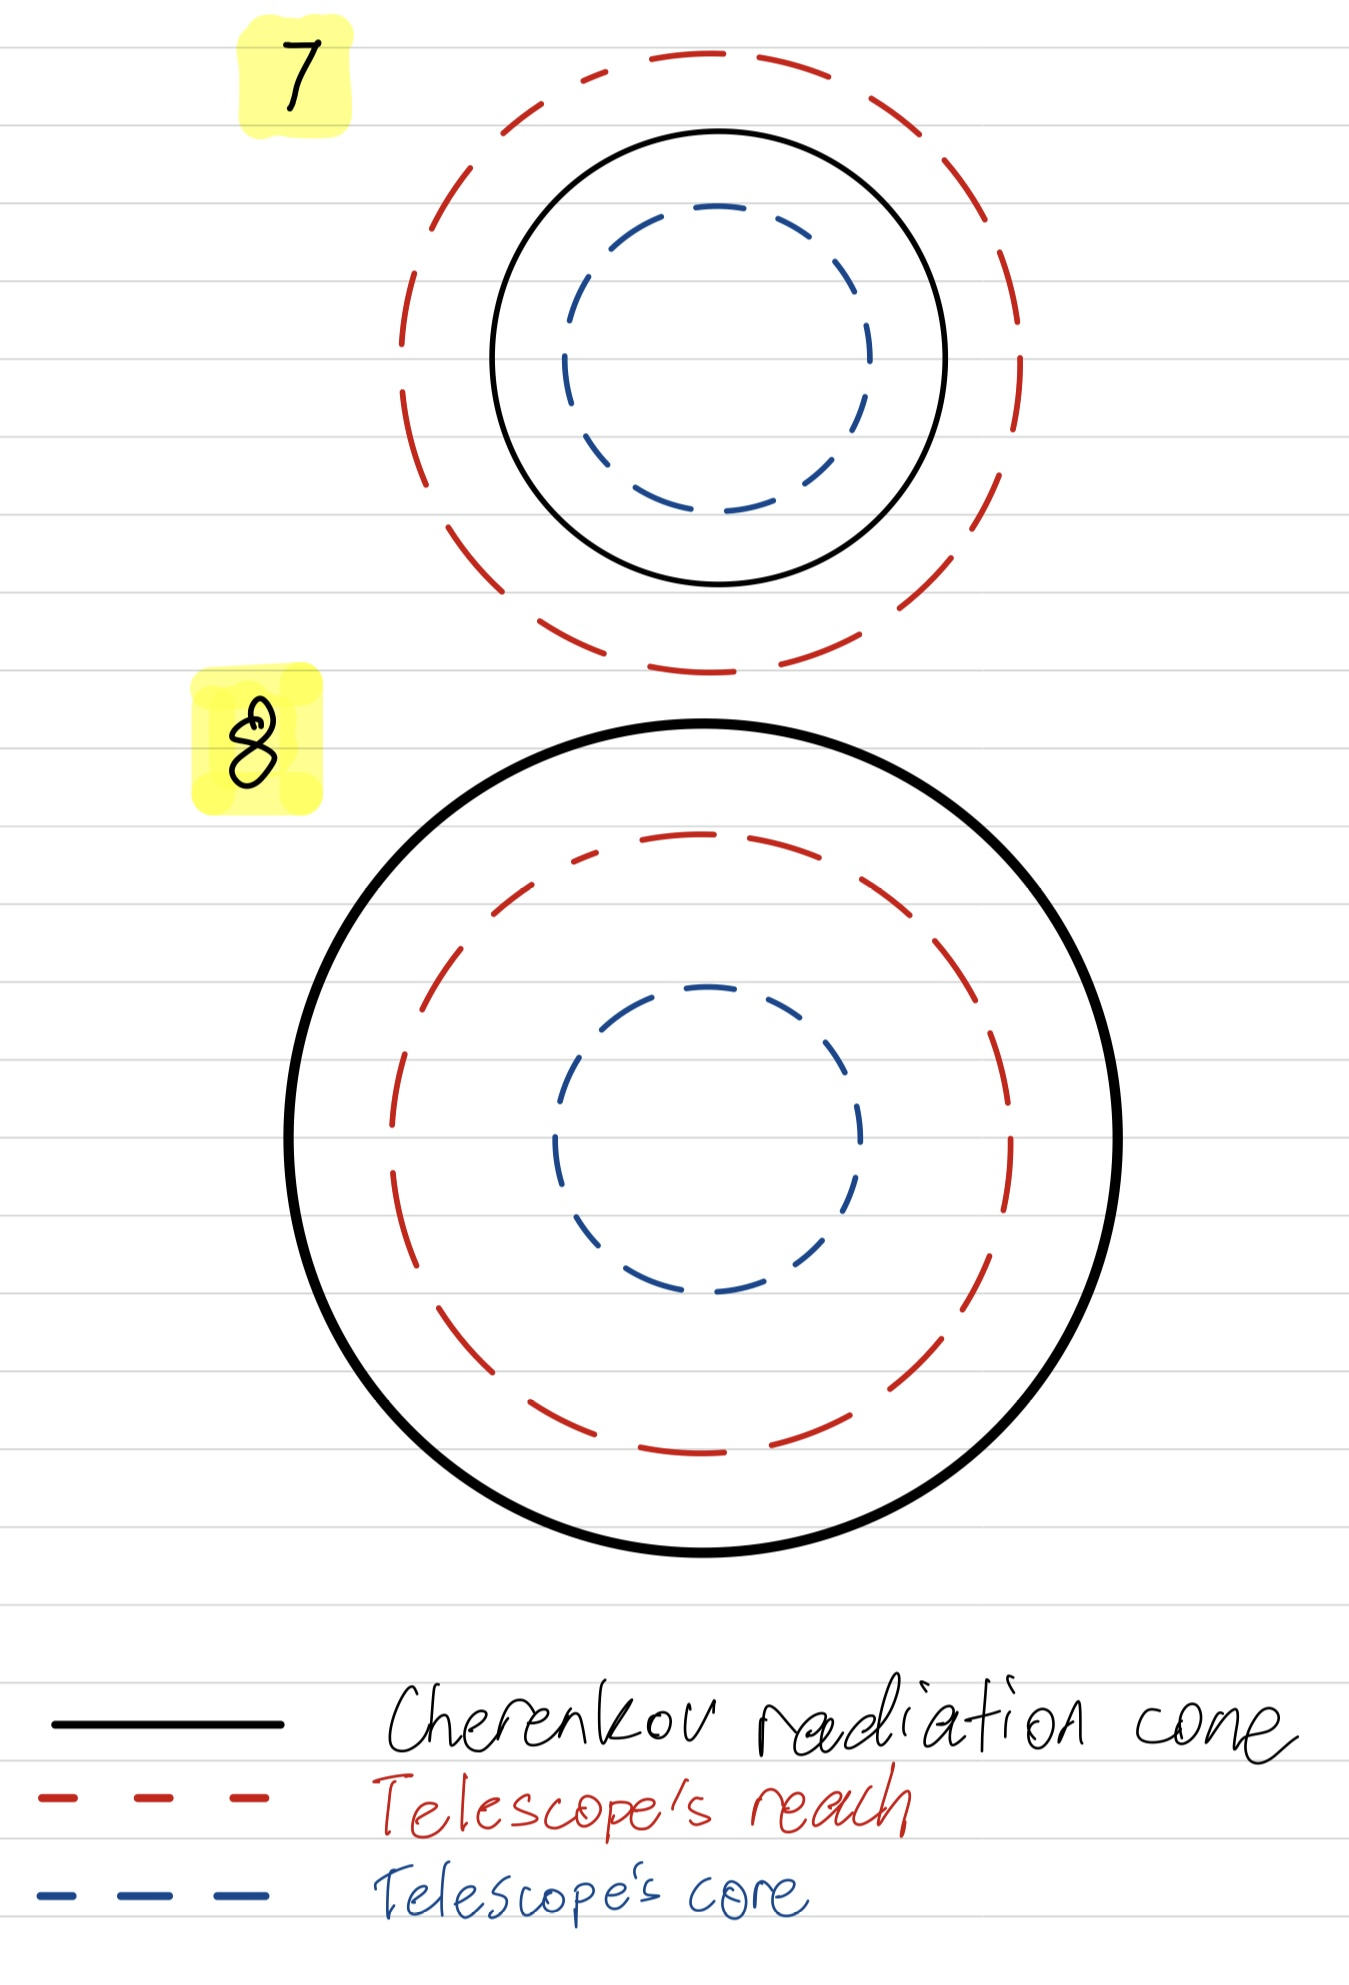

In [2]:
def graphCircles(cone_pos=(0, 0), tel_pos=(0, 0), r_cone=1, r_tel_core=1, r_tel_reach=2):
  # Define the circle
  theta = np.linspace(0, 2 * np.pi, 100)
  x = np.cos(theta)
  y = np.sin(theta)

  # Create the plot
  plt.figure(figsize=(6,6))

  # Plot the solid circle
  plt.plot(cone_pos[0] + x*r_cone, cone_pos[1] + y*r_cone, label='Shower Cone', linestyle='-', color='black')

  # Plot the dashed circle
  plt.plot(tel_pos[0] + x*r_tel_core, tel_pos[1] + y*r_tel_core, label='Inner Annulus', linestyle='--', color='red')
  plt.plot(tel_pos[0] + x*r_tel_reach, tel_pos[1] + y*r_tel_reach, label='Outer Annulus', linestyle='--', color='blue')

  # Add labels and title
  plt.title('Shower cone and telescope projection')
  plt.xlabel('X-axis')
  plt.ylabel('Y-axis')

  # Set aspect ratio to equal to make the circle look like a circle
  plt.gca().set_aspect('equal', adjustable='box')

  # Show legend
  plt.legend()

  # Display the plot
  plt.grid(True)
  plt.show()

In [3]:
def getIntersectionPoints(new_tel_pos=(0, 0), cone_r=1, tel_r=1):
  # Cone position assumed to be at (0, 0) with radius r
  # Center of telescope at (L, h) with radius R
  # Define constants

  r = cone_r
  R = tel_r
  L = new_tel_pos[0]
  h = new_tel_pos[1]
  K = R**2 - r**2 - L**2 - h**2

  # Define a b and c in quadratic formula
  a = 4*(h**2) + 4*(L**2)
  b = 4*K*h
  c = (K**2) - 4*(L**2)*(r**2)

  # Calculate y-values (roots)
  roots = np.roots([a, b, c])

  x = [None, None]

  for idx, y in enumerate(roots):
    cone_xs = [np.sqrt(r**2-y**2), -np.sqrt(r**2-y**2)]
    annulus_xs = [np.sqrt(R**2 - (y-h)**2) + L, -(np.sqrt(R**2 - (y-h)**2) + L)]

    if (np.isclose(cone_xs[0], annulus_xs[0])): x[idx] = cone_xs[0]
    elif (np.isclose(cone_xs[0], annulus_xs[1])): x[idx] = cone_xs[0]
    elif (np.isclose(cone_xs[1], annulus_xs[1])): x[idx] = cone_xs[0]

  return (x[0], roots[0]), (x[1], roots[1])

points = getIntersectionPoints(new_tel_pos = (1, 1), cone_r = 2, tel_r = 2)
print(points)

((None, 1.8228756555322954), (1.8228756555322954, -0.8228756555322952))


## Computing $'\delta\omega'$
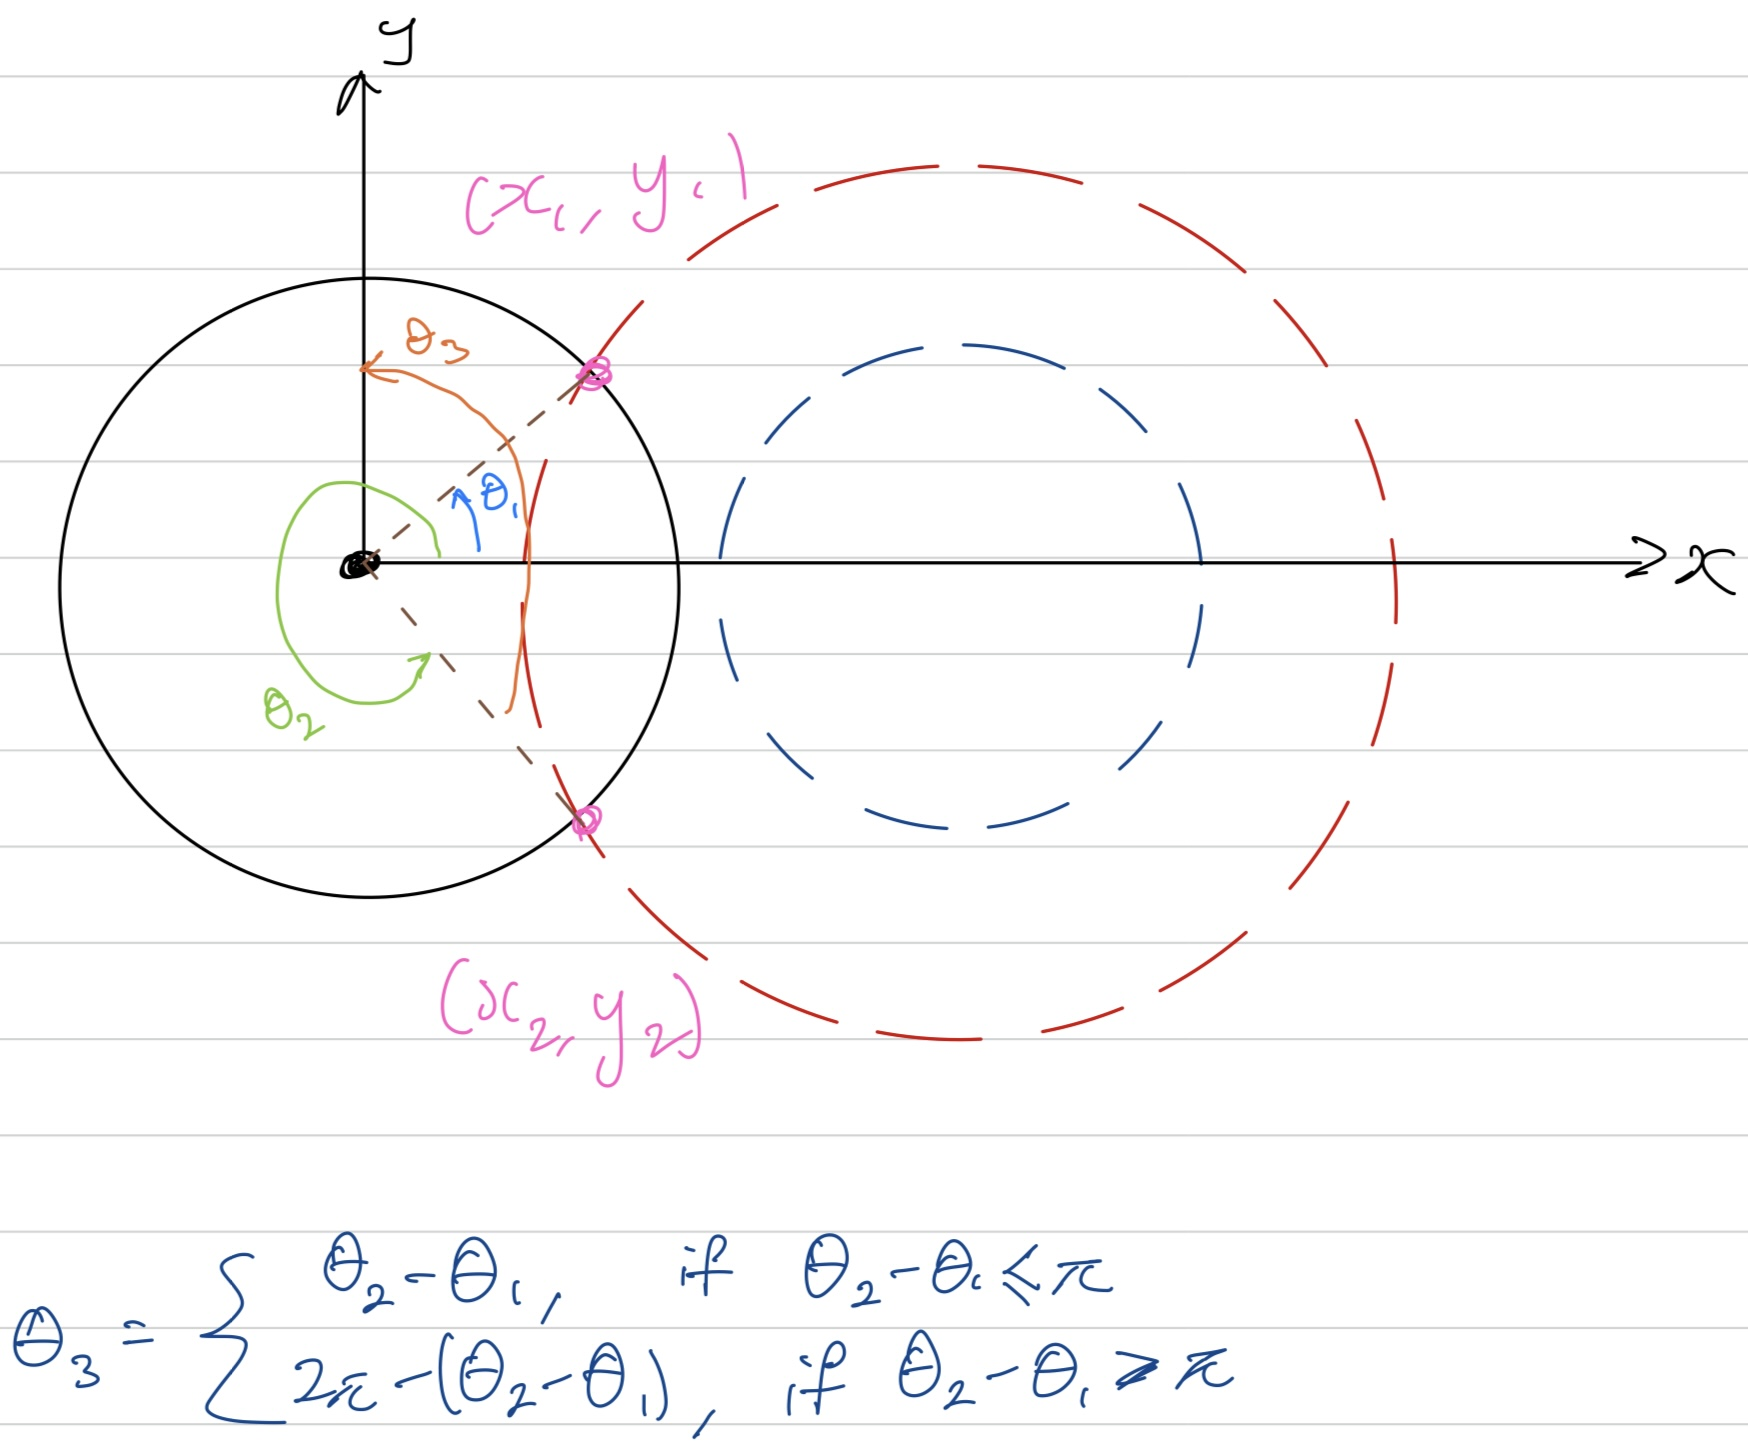

In [4]:
def calculateOmegaFromPoints(point1, point2):
  angle1 = np.arctan(point1[1]/point1[0])
  angle2 = np.arctan(point2[1]/point2[0])

  diff = angle1 - angle2
  return np.abs(2*np.pi - diff) if diff > np.pi else np.abs(diff)

In [5]:
def getClosestPoint(point, pair):
  getDistance = lambda p1, p2: np.sqrt((p1[0] - p2[0])**2 + (p1[1] - p2[1])**2)

  p0_dist = getDistance(point, pair[0])
  p1_dist = getDistance(point, pair[1])

  if p0_dist > p1_dist:
    return pair[0]
  elif p0_dist < p1_dist:
    return pair[1]
  else:
    print("Error detected!: Equal distance between target point and pair provided in getClosestPoint function")
    return (0, 0)


In [6]:
def getOmegas(cone_pos=(0, 0), tel_pos=(0, 0), r_cone=1, r_tel_core=1, r_tel_reach=2):
  # Shift reference frame so that
  # Shower cone center is at the origin
  new_cone_pos = (0, 0)
  new_tel_pos = (tel_pos[0] - cone_pos[0], tel_pos[1] - cone_pos[1])

  # Define constant
  dist = np.sqrt(new_tel_pos[0]**2 + new_tel_pos[1]**2)

  outside_tel_reach = dist >= r_cone + r_tel_reach
  inside_tel_reach = dist <= r_tel_reach - r_cone
  intersect_tel_reach = ~outside_tel_reach and ~inside_tel_reach

  outside_tel_core = dist >= r_tel_core + r_cone
  inside_tel_core = dist <= r_tel_core - r_cone
  intersect_tel_core = ~outside_tel_core and ~inside_tel_core

  tel_reach_inside_cone = dist <= r_cone - r_tel_reach
  tel_core_inside_cone = dist <= r_cone - r_tel_core

  ### No intersection cases
  # Case 1
  if (outside_tel_reach):
    return []
  # Case 4
  elif (inside_tel_reach and outside_tel_core):
    return [2*np.pi]
  # Case 6
  elif (inside_tel_core):
    return []
  # Case 7
  elif (inside_tel_reach and tel_core_inside_cone):
    return [2*np.pi]
  # Case 8
  elif (tel_reach_inside_cone):
    return []

  ### One pair of intersection points
  # Case 2
  if (intersect_tel_reach and not intersect_tel_core):
    points = getIntersectionPoints(new_tel_pos, r_cone, r_tel_reach)
    omega = calculateOmegaFromPoints(points[0], points[1])
    return [omega]
  # Case 5
  elif (intersect_tel_core and not intersect_tel_reach):
    print("JEY")
    points = getIntersectionPoints(new_tel_pos, r_cone, r_tel_core)
    omega = calculateOmegaFromPoints(points[0], points[1])
    return [omega]

  ### 2 pairs of intersection points (2 omega angles)
  # Case 3
  if (intersect_tel_reach and intersect_tel_core):
    core_pair = getIntersectionPoints(new_tel_pos, r_cone, r_tel_core)
    reach_pair = getIntersectionPoints(new_tel_pos, r_cone, r_tel_reach)

    pair1 = (core_pair[0], getClosestPoint(core_pair[0], reach_pair))
    pair2 = (core_pair[1], getClosestPoint(core_pair[1], reach_pair))

    print(pair1)
    print(pair2)

    omega1 = calculateOmegaFromPoints(pair1[0], pair1[1])
    omega2 = calculateOmegaFromPoints(pair1[0], pair1[1])

    return [omega1, omega2]

  print("NO CASES MATCHED????")
  return []

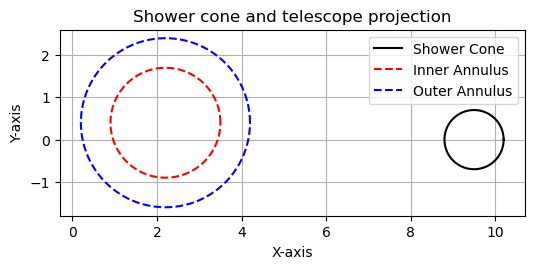

[]


In [7]:
graphCircles(cone_pos=(9.5, 0), tel_pos=(2.2, 0.4), r_cone=0.7, r_tel_core=1.3, r_tel_reach=2)
print(getOmegas(cone_pos=(9.5, 0), tel_pos=(2.2, 0.4), r_cone=0.7, r_tel_core=1.3, r_tel_reach=2))

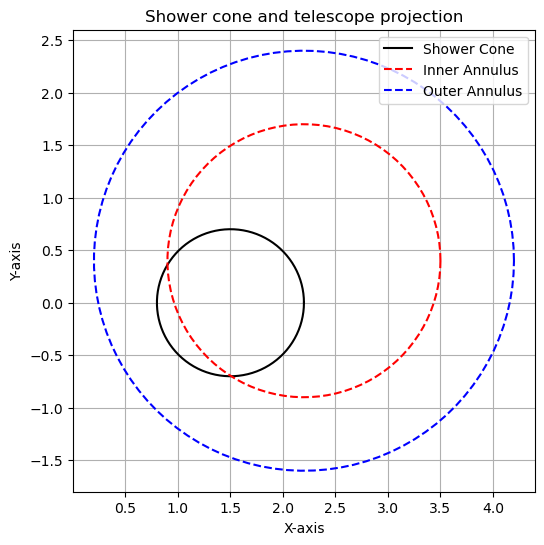

JEY


TypeError: unsupported operand type(s) for /: 'float' and 'NoneType'

In [8]:
graphCircles(cone_pos=(1.5, 0), tel_pos=(2.2, 0.4), r_cone=0.7, r_tel_core=1.3, r_tel_reach=2)
print(np.array(getOmegas(cone_pos=(1.5, 0), tel_pos=(2.2, 0.4), r_cone=0.7, r_tel_core=1.3, r_tel_reach=2)) * 180/np.pi)

In [ ]:
graphCircles(cone_pos=(4.5, 0), tel_pos=(2.2, 0.4), r_cone=0.7, r_tel_core=1.3, r_tel_reach=2)
print(np.array(getOmegas(cone_pos=(4.5, 0), tel_pos=(2.2, 0.4), r_cone=0.7, r_tel_core=1.3, r_tel_reach=2)) * 180/np.pi)

In [ ]:
graphCircles(cone_pos=(3.5, 0), tel_pos=(2.2, 0.4), r_cone=0.7, r_tel_core=1.3, r_tel_reach=2)
print(np.array(getOmegas(cone_pos=(3.5, 0), tel_pos=(2.2, 0.4), r_cone=0.7, r_tel_core=1.3, r_tel_reach=2)) * 180/np.pi)